In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import adios2

In [2]:
adios  = adios2.ADIOS(configFile="adios2.xml")                     # Use the configurations defined in "adios2.xml"...
io     = adios.DeclareIO("readerIO")                               # ... in the section "readerIO"
engine = io.Open("diffusion2D.bp", adios2.Mode.Read)               # Open the file/stream "diffusion2D.bp"
engine.Type()                                                      # Check the type of the engine: BP4/SST...

'SstReader'

In [3]:
io.AvailableVariables()                                            # There are no available variables before the first step when using SST

{}

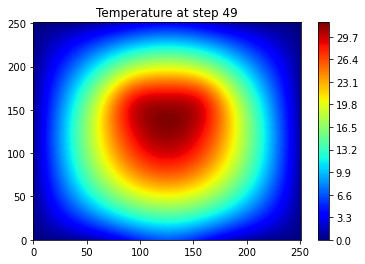

In [4]:
nprocessed=0
while engine.BeginStep(mode=adios2.StepMode.Read,timeoutSeconds=100.0) != adios2.StepStatus.EndOfStream :  # Begin the next ADIOS2 read step while there is any
    T_id = io.InquireVariable("temperature")                       # Get a handle for the variable T. ATTENTION: T_id is only valid for the current step when using streaming (SST or file streaming); thus, moving it into the if statement below would lead to an error!
    if nprocessed == 0:
        nxy_global = T_id.Shape()                                  # Extract meta data
        nxy        = T_id.Count()                                  # ...
        T_type     = T_id.Type()                                   # ...
        T          = np.zeros(nxy, dtype=T_type)                   # Prealocate memory for T using the meta data
        print(nxy_global, nxy, T_type); sleep(4)                   # Note that nxy==nxy_global as we read only with one process
    engine.Get(T_id, T)                                            # Add T to variable(s) for reading (SetSelection() would be needed in addition if we were reading the data with multiple MPI processes: this would make sure that every process reads "his" block)        
    engine.EndStep()                                               # End ADIOS2 read step (includes normally the actual reading of data)
    IPython.display.clear_output(wait=True)                        # Pass wait=True to wait until new ouput before clearing; this prevents flickering
    plt.title('Temperature at step ' + str(engine.CurrentStep()))  # Plot the temperature
    plt.contourf(T, 256, cmap=plt.cm.jet)                          # ...
    plt.colorbar()                                                 # ...
    plt.show()                                                     # ...
    nprocessed += 1

In [4]:
engine.Close()